In [24]:
import sys
sys.path.append("..")


from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import ipywidgets as ipw
import numpy as np 
from tqdm.notebook import tqdm

from imitative_agent import ImitativeAgent
from communicative_agent.communicative_agent import CommunicativeAgent
from quantizer.quantizer import Quantizer

from lib.dataset_wrapper import Dataset
from lib import utils
from lib import abx_utils

ABX_NB_SAMPLES = 500
AGENT_ABX_DISTANCES = [
    { 
        "art_estimated": {
            "metric": "cosine",
            "weight": 1,
        }
    },
    {
        "art_units": {
            "metric": "cosine",
            "weight": 1,
        }
    }
]

agent_path = Path('../out/communicative_vs_imitative')
seeds = [0, 1, 2, 3, 4]
# Create alias
agents_alias = {}
for seed in seeds:
    agent_file = agent_path / f'imitative_jerk_gan_{seed}'
    agent = ImitativeAgent.reload(str(agent_file), load_nn=False)
    config = agent.config
        
    agent_alias = " ".join((
        f"{','.join(config['dataset']['names'])}",
        f"jerk_loss_weight={config['training']['jerk_loss_weight']}",
        f"discriminator_loss_weight={config['training']['discriminator_loss_weight']}",
        f"seed={config['dataset']['datasplit_seed']}",
        f"path={agent_file}",
    ))
    agents_alias[agent_alias] = agent_file

# Compute ABX 
agents_abx_matrices = utils.pickle_load(agent_path / 'abx_cache.pickle', {})
for agent_alias, agent_file in tqdm(agents_alias.items()):
    agent = ImitativeAgent.reload(str(agent_file))
    quantizer_file = f'../out/quantizer/imitative_jerk_gan_{seed}'
    agent.art_quantizer = Quantizer.reload(str(quantizer_file), load_nn=True)
    agent.nn.art_quantizer = agent.art_quantizer.nn
    
    main_dataset = agent.get_main_dataset()
    agent_lab = agent.get_datasplit_lab(2)
    
    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, vowels)
    
    if agent_file not in agents_abx_matrices:
        agents_abx_matrices[agent_file] = {}
    agent_abx_matrices = agents_abx_matrices[agent_file]
    
    for distance in AGENT_ABX_DISTANCES:
        distance_signature = abx_utils.get_distance_signature(distance)
        if distance_signature in agent_abx_matrices: continue
        agent_features = agent.repeat_datasplit(2)
        abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, agent_features, distance, ABX_NB_SAMPLES, seed=43)
        agent_abx_matrices[distance_signature] = abx_matrix
        utils.pickle_dump(agent_path / 'abx_cache.pickle', agents_abx_matrices)

# Print ABX
for distance in AGENT_ABX_DISTANCES:
    abx_manner = []
    abx_place = []
    abx_global = []
    for seed in seeds:
        agent_file = agent_path / f'imitative_jerk_gan_{seed}'
        distance_signature = abx_utils.get_distance_signature(distance)
        agent_abx_matrix = agents_abx_matrices[agent_file][distance_signature]
        groups_score = abx_utils.get_groups_score(consonants, agent_abx_matrix, main_dataset.phones_infos["consonant_groups"])
        global_score = abx_utils.get_global_score(agent_abx_matrix)
        abx_manner.append(groups_score['manner'])
        abx_place.append(groups_score['place'])
        abx_global.append(global_score)
    print(f"Imitative agent, {list(distance.keys())[0]}")
    print(f'N={len(abx_global)}')
    print('ABX place : mu=%.1f, std=%.1f' % (np.mean(abx_place), np.std(abx_place, ddof=1)))
    print(f'ABX manner: mu=%.1f, std=%.1f' % (np.mean(abx_manner), np.std(abx_manner, ddof=1)))
    print(f'ABX global: mu=%.1f, std=%.1f' % (np.mean(abx_global), np.std(abx_global, ddof=1)))
    print(abx_place)
    print(abx_manner)

  0%|          | 0/5 [00:00<?, ?it/s]

Imitative agent, art_estimated
N=5
ABX place : mu=66.8, std=7.0
ABX manner: mu=75.8, std=5.2
ABX global: mu=79.1, std=4.6
[74.375, 70.25, 59.04166666666666, 59.81666666666666, 70.725]
[78.59666666666668, 75.22999999999999, 77.33333333333334, 67.16333333333333, 80.77]
Imitative agent, art_units
N=5
ABX place : mu=67.6, std=8.7
ABX manner: mu=76.4, std=7.4
ABX global: mu=79.4, std=7.3
[76.25, 71.29166666666666, 56.81666666666667, 59.858333333333334, 73.7]
[81.38333333333333, 78.47, 73.25, 65.21000000000001, 83.68]


In [5]:
# Compute gold ABX on art_real
distance = {
        "art_real": {
            "metric": "cosine",
            "weight": 1,
        },
    }

seeds = [0, 1, 2, 3, 4] # [0, 1, 2, 3, 4]
gold_art_abx_manner = []
gold_art_abx_place = []
gold_art_abx_global = []
for seed in tqdm(seeds):
    agent_file = agent_path / f'imitative_{seed}'
    agent = ImitativeAgent.reload(str(agent_file))
    main_dataset = agent.get_main_dataset()
    agent_lab = agent.get_datasplit_lab(2)
    real_art_params = main_dataset.get_items_modality_data('art_params', cut_silences=False)
    real_features = {'pb2007': {'art_real': {item:real_art_params[item] for item in agent_lab['pb2007'].keys()}}}
    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, vowels)
    abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, real_features, distance, ABX_NB_SAMPLES, seed=43)
    agent_abx_matrices[distance_signature] = abx_matrix
    groups_score = abx_utils.get_groups_score(consonants, abx_matrix, main_dataset.phones_infos["consonant_groups"])
    global_score = abx_utils.get_global_score(abx_matrix)
    gold_art_abx_manner.append(groups_score['manner'])
    gold_art_abx_place.append(groups_score['place'])
    gold_art_abx_global.append(global_score)
    
print("Gold articulatory parameters (continuous)")
print(f'N={len(gold_art_abx_global)}')
print('ABX place : mu=%.1f, std=%.1f' % (np.mean(gold_art_abx_place), np.std(gold_art_abx_place, ddof=1)))
print(f'ABX manner: mu=%.1f, std=%.1f' % (np.mean(gold_art_abx_manner), np.std(gold_art_abx_manner, ddof=1)))
print(f'ABX global: mu=%.1f, std=%.1f' % (np.mean(gold_art_abx_global), np.std(gold_art_abx_global, ddof=1)))

  0%|          | 0/5 [00:00<?, ?it/s]

Gold articulatory parameters (continuous)


NameError: name 'abx_global' is not defined

In [6]:
# Compute gold ABX on cepstrum
distance = {
        "cepstrum_real": {
            "metric": "cosine",
            "weight": 1,
        },
    }

seeds = [0, 1, 2, 3, 4] # [0, 1, 2, 3, 4]
gold_cep_abx_manner = []
gold_cep_abx_place = []
gold_cep_abx_global = []
for seed in tqdm(seeds):
    agent_file = agent_path / f'imitative_{seed}'
    agent = ImitativeAgent.reload(str(agent_file))
    main_dataset = agent.get_main_dataset()
    agent_lab = agent.get_datasplit_lab(2)
    real_cepstrum = main_dataset.get_items_modality_data('cepstrum', cut_silences=False)
    real_features = {'pb2007': {'cepstrum_real': {item:real_cepstrum[item] for item in agent_lab['pb2007'].keys()}}}
    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, vowels)
    abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, real_features, distance, ABX_NB_SAMPLES, seed=43)
    agent_abx_matrices[distance_signature] = abx_matrix
    groups_score = abx_utils.get_groups_score(consonants, abx_matrix, main_dataset.phones_infos["consonant_groups"])
    global_score = abx_utils.get_global_score(abx_matrix)
    gold_cep_abx_manner.append(groups_score['manner'])
    gold_cep_abx_place.append(groups_score['place'])
    gold_cep_abx_global.append(global_score)
    
print("Gold cepstrum (continuous)")
print(f'N={len(gold_cep_abx_global)}')
print('ABX place : mu=%.1f, std=%.1f' % (np.mean(gold_cep_abx_place), np.std(gold_cep_abx_place, ddof=1)))
print(f'ABX manner: mu=%.1f, std=%.1f' % (np.mean(gold_cep_abx_manner), np.std(gold_cep_abx_manner, ddof=1)))
print(f'ABX global: mu=%.1f, std=%.1f' % (np.mean(gold_cep_abx_global), np.std(gold_cep_abx_global, ddof=1)))

  0%|          | 0/5 [00:00<?, ?it/s]

Gold cepstrum (continuous)
N=5
ABX place : mu=70.8, std=0.8
ABX manner: mu=91.6, std=0.7
ABX global: mu=88.1, std=1.0


In [37]:
# Compute gold ABX on art_units
distance = {
        "quantized_latent": {
            "metric": "cosine",
            "weight": 1,
        },
    }


agent_path = Path('../out/quantizer')
basenames = ['c7502a9c6785e296b8076f4ddf64e2cb-4',
            'b59c32ccdc0f8e136e5c4f51163c7308-3',
            '3150462b1f57842881793e1f2ee97dd7-2',
            '5de8ab6795d0761e683c8b17b8ccb0ed-1',
            '5a62e02b1f4b948fc182f3ce77fe78b3-0']
gold_qart_abx_manner = []
gold_qart_abx_place = []
gold_qart_abx_global = []
for basename in tqdm(basenames):
    agent_file = agent_path / basename
    agent = Quantizer.reload(str(agent_file))
    main_dataset = agent.main_dataset
    quantizer_lab = agent.get_datasplit_lab(2)
    quantizer_features = agent.autoencode_datasplit(2)
    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    consonants_indexes = abx_utils.get_datasets_phones_indexes(quantizer_lab, consonants, vowels)
    abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, quantizer_features, distance, ABX_NB_SAMPLES, seed=43)
    agent_abx_matrices[distance_signature] = abx_matrix
    groups_score = abx_utils.get_groups_score(consonants, abx_matrix, main_dataset.phones_infos["consonant_groups"])
    global_score = abx_utils.get_global_score(abx_matrix)
    gold_qart_abx_manner.append(groups_score['manner'])
    gold_qart_abx_place.append(groups_score['place'])
    gold_qart_abx_global.append(global_score)
    
print("Gold articulatory parameters (continuous)")
print(f'N={len(gold_qart_abx_global)}')
print('ABX place : mu=%.1f, std=%.1f' % (np.mean(gold_qart_abx_place), np.std(gold_qart_abx_place, ddof=1)))
print(f'ABX manner: mu=%.1f, std=%.1f' % (np.mean(gold_qart_abx_manner), np.std(gold_qart_abx_manner, ddof=1)))
print(f'ABX global: mu=%.1f, std=%.1f' % (np.mean(gold_qart_abx_global), np.std(gold_qart_abx_global, ddof=1)))

  0%|          | 0/5 [00:00<?, ?it/s]

Gold articulatory parameters (continuous)
N=5
ABX place : mu=91.7, std=2.7
ABX manner: mu=65.0, std=1.8
ABX global: mu=84.1, std=2.1


In [42]:
# Compute gold ABX on sound_units
distance = {
        "quantized_latent": {
            "metric": "cosine",
            "weight": 1,
        },
    }

agent_path = Path('../out/quantizer')
basenames = ['a722eccbf1451d4931a277b2c721f64e-0',
             'e1bdb5d1cdf914f94952ada14d69cde5-1',
             'ce8f3fdc5d22ccedbd090849107f6994-2',
             '4be8cc80d3dee54979aded2bf85f175e-3',
             'f50650bb40e1346ed24011c2e41b7153-4']
gold_qcep_abx_manner = []
gold_qcep_abx_place = []
gold_qcep_abx_global = []
for basename in tqdm(basenames):
    agent_file = agent_path / basename
    agent = Quantizer.reload(str(agent_file))
    main_dataset = agent.main_dataset
    quantizer_lab = agent.get_datasplit_lab(2)
    quantizer_features = agent.autoencode_datasplit(2)
    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    consonants_indexes = abx_utils.get_datasets_phones_indexes(quantizer_lab, consonants, vowels)
    abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, quantizer_features, distance, ABX_NB_SAMPLES, seed=43)
    agent_abx_matrices[distance_signature] = abx_matrix
    groups_score = abx_utils.get_groups_score(consonants, abx_matrix, main_dataset.phones_infos["consonant_groups"])
    global_score = abx_utils.get_global_score(abx_matrix)
    gold_qcep_abx_manner.append(groups_score['manner'])
    gold_qcep_abx_place.append(groups_score['place'])
    gold_qcep_abx_global.append(global_score)
    
print("Gold cepstrum (continuous)")
print(f'N={len(gold_qcep_abx_global)}')
print('ABX place : mu=%.1f, std=%.1f' % (np.mean(gold_qcep_abx_place), np.std(gold_qcep_abx_place, ddof=1)))
print(f'ABX manner: mu=%.1f, std=%.1f' % (np.mean(gold_qcep_abx_manner), np.std(gold_qcep_abx_manner, ddof=1)))
print(f'ABX global: mu=%.1f, std=%.1f' % (np.mean(gold_qcep_abx_global), np.std(gold_qcep_abx_global, ddof=1)))

  0%|          | 0/5 [00:00<?, ?it/s]

Gold cepstrum (continuous)
N=5
ABX place : mu=68.6, std=0.8
ABX manner: mu=91.1, std=1.1
ABX global: mu=89.6, std=0.8


In [1]:
# Comparison communicative/imitative: graph
import sys
sys.path.append("..")
sys.path.append("../communicative_agent")

from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import ipywidgets as ipw
import numpy as np 
from tqdm.notebook import tqdm

from imitative_agent import ImitativeAgent
from communicative_agent import CommunicativeAgent
from quantizer.quantizer import Quantizer

from lib.dataset_wrapper import Dataset
from lib import utils
from lib import abx_utils

ABX_NB_SAMPLES = 500
AGENT_ABX_DISTANCES_IMIT = [
    { 
        "art_estimated": {
            "metric": "cosine",
            "weight": 1,
        }
    }
]
AGENT_ABX_DISTANCES_COMMU = [
    { 
        "art_units": {
            "metric": "cosine",
            "weight": 1,
        }
    }
]
agent_path = Path('../out/communicative_vs_imitative')
conditions = ['imitative', 'communicative', 'imitative_jerk', 'communicative_jerk', 'imitative_gan', 'communicative_gan', 'imitative_jerk_gan', 'communicative_jerk_gan']
seeds = [0, 1, 2, 3, 4]
agents_alias = {}

for condition in conditions:
    for seed in seeds:
        agent_file = agent_path / f'{condition}_{seed}'
        if condition.startswith('imitative'):
            agent = ImitativeAgent.reload(str(agent_file), load_nn=False)
        else:
            agent = CommunicativeAgent.reload(str(agent_file), load_nn=False)
        config = agent.config
        agent_alias = " ".join((
            f"jerk_loss_weight={config['training']['jerk_loss_weight']}",
            f"discriminator_loss_weight={config['training']['discriminator_loss_weight']}",
            f"path={agent_file}",
            f"seed={seed}",
            f"condition={condition}"
        ))
        agents_alias[agent_alias] = agent_file

# Compute ABX 
agents_abx_matrices = utils.pickle_load(agent_path / 'abx_cache.pickle', {})
for agent_alias, agent_file in tqdm(agents_alias.items()):
    
    # Load right agent
    if agent_alias.split(' ')[-1].startswith('condition=imitative'):
        agent = ImitativeAgent.reload(str(agent_file))
        main_dataset = agent.get_main_dataset()
        agent_lab = agent.get_datasplit_lab(2)
        AGENT_ABX_DISTANCES = AGENT_ABX_DISTANCES_IMIT
    else:
        agent = CommunicativeAgent.reload(str(agent_file))
        quantizer_file = f'../out/quantizer/{condition}_{seed}'
        agent.art_quantizer = Quantizer.reload(str(quantizer_file), load_nn=True)
        agent.nn.art_quantizer = agent.art_quantizer.nn
        main_dataset = Dataset(agent.sound_quantizer.config['dataset']['names'][0])
        agent_lab = agent.sound_quantizer.get_datasplit_lab(2)
        agent.config['dataset'] = {}
        agent.config['dataset']["names"] = ["pb2007"]
        agent.config['dataset'] = agent.sound_quantizer.config['dataset']
        agent.config['dataset']['sound_type'] = 'cepstrum'
        AGENT_ABX_DISTANCES = AGENT_ABX_DISTANCES_COMMU
    
    
    # ABX computation
    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, vowels)
    
    if agent_file not in agents_abx_matrices:
        agents_abx_matrices[agent_file] = {}
    agent_abx_matrices = agents_abx_matrices[agent_file]
    
    for distance in AGENT_ABX_DISTANCES:
        distance_signature = abx_utils.get_distance_signature(distance)
        if distance_signature in agent_abx_matrices: continue
        agent_features = agent.repeat_datasplit(2)
        abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, agent_features, distance, ABX_NB_SAMPLES, seed=43)
        agent_abx_matrices[distance_signature] = abx_matrix
        utils.pickle_dump(agent_path / 'abx_cache.pickle', agents_abx_matrices)

# Print ABX
results = {}
for condition in conditions:
    if condition.startswith('communicative'):
        AGENT_ABX_DISTANCES = AGENT_ABX_DISTANCES_COMMU
    else:
        AGENT_ABX_DISTANCES = AGENT_ABX_DISTANCES_IMIT
    for seed in seeds:
        for distance in AGENT_ABX_DISTANCES:
            if condition not in results: 
                results[condition] = {}
            
            feature_name = list(distance.keys())[0]
            if feature_name not in results[condition]:
                results[condition][feature_name] = {'manner': [], 'place': [], 'global': []}
                
            agent_file = agent_path / f'{condition}_{seed}'
            distance_signature = abx_utils.get_distance_signature(distance)
            agent_abx_matrix = agents_abx_matrices[agent_file][distance_signature]
            groups_score = abx_utils.get_groups_score(consonants, agent_abx_matrix, main_dataset.phones_infos["consonant_groups"])
            global_score = abx_utils.get_global_score(agent_abx_matrix)
            results[condition][feature_name]['manner'].append(groups_score['manner'])
            results[condition][feature_name]['place'].append(groups_score['place'])
            results[condition][feature_name]['global'].append(global_score)

  0%|          | 0/40 [00:00<?, ?it/s]

In [7]:
conditions = ['communicative', 'communicative_jerk', 'communicative_gan', 'communicative_jerk_gan']
for condition in conditions:
    print(condition)
    samples = results[condition]['art_estimated']['global']
    print("global", np.mean(samples), np.std(samples, ddof=1))
    samples = results[condition]['art_estimated']['place']
    print("place", np.mean(samples), np.std(samples, ddof=1))
    samples = results[condition]['art_estimated']['manner']
    print("manner", np.mean(samples), np.std(samples, ddof=1))

communicative
global 84.18573099415205 1.4391577971188676
place 67.34333333333333 1.2564748969504598
manner 84.62133333333333 2.173318762732346
communicative_jerk
global 81.90584795321638 2.356642830829221
place 66.02833333333334 0.9747257449035545
manner 83.41066666666667 2.653777600997407
communicative_gan
global 81.07169590643275 1.8368048034699893
place 66.02666666666667 2.3267794862809343
manner 81.30733333333333 2.59091725499334
communicative_jerk_gan
global 75.0583625730994 8.925952271476088
place 61.49333333333334 8.160629996786062
manner 73.388 10.201607062941926


In [54]:
# Only COMMUNICATIVE AGENT on quantized articulatory units
import sys
sys.path.append("..")
sys.path.append("../communicative_agent")

from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import ipywidgets as ipw
import numpy as np 
from tqdm.notebook import tqdm

from communicative_agent import CommunicativeAgent
from quantizer.quantizer import Quantizer

from lib.dataset_wrapper import Dataset
from lib import utils
from lib import abx_utils

ABX_NB_SAMPLES = 500
AGENT_ABX_DISTANCES = [
    { 
        "art_units": {
            "metric": "cosine",
            "weight": 1,
        }
    }
]

agent_path = Path('../out/communicative_vs_imitative')
conditions = ['communicative', 'communicative_jerk', 'communicative_gan', 'communicative_jerk_gan']
seeds = [0, 1, 2, 3, 4]
agents_alias = {}

for condition in conditions:
    for seed in seeds:
        agent_file = agent_path / f'{condition}_{seed}'
        agent = CommunicativeAgent.reload(str(agent_file), load_nn=False)
        config = agent.config
        agent_alias = " ".join((
            f"jerk_loss_weight={config['training']['jerk_loss_weight']}",
            f"discriminator_loss_weight={config['training']['discriminator_loss_weight']}",
            f"path={agent_file}",
            f"seed={seed}",
            f"condition={condition}"
        ))
        agents_alias[agent_alias] = agent_file

# Compute ABX 
agents_abx_matrices = utils.pickle_load(agent_path / 'abx_cache_quant.pickle', {})
for agent_alias, agent_file in tqdm(agents_alias.items()):
    
    # Load agent
    agent = CommunicativeAgent.reload(str(agent_file))
    main_dataset = Dataset(agent.sound_quantizer.config['dataset']['names'][0])
    agent_lab = agent.sound_quantizer.get_datasplit_lab(2)
    agent.config['dataset'] = {}
    agent.config['dataset']["names"] = ["pb2007"]
    agent.config['dataset'] = agent.sound_quantizer.config['dataset']
    agent.config['dataset']['sound_type'] = 'cepstrum'
    
    quantizer_file = f'../out/quantizer/{agent_file.name}'
    agent.art_quantizer = Quantizer.reload(str(quantizer_file), load_nn=True)
    agent.nn.art_quantizer = agent.art_quantizer.nn
    
    # ABX computation
    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, vowels)
    
    if agent_file not in agents_abx_matrices:
        agents_abx_matrices[agent_file] = {}
    agent_abx_matrices = agents_abx_matrices[agent_file]
    
    for distance in AGENT_ABX_DISTANCES:
        distance_signature = abx_utils.get_distance_signature(distance)
        if distance_signature in agent_abx_matrices: continue
        agent_features = agent.repeat_datasplit(2)
        abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, agent_features, distance, ABX_NB_SAMPLES, seed=43)
        agent_abx_matrices[distance_signature] = abx_matrix
        utils.pickle_dump(agent_path / 'abx_cache_quant.pickle', agents_abx_matrices)

# Print ABX
results_quant = {}
for condition in conditions:
    for seed in seeds:
        for distance in AGENT_ABX_DISTANCES:
            if condition not in results_quant: 
                results_quant[condition] = {}
            
            feature_name = list(distance.keys())[0]
            if feature_name not in results_quant[condition]:
                results_quant[condition][feature_name] = {'manner': [], 'place': [], 'global': []}
                
            agent_file = agent_path / f'{condition}_{seed}'
            distance_signature = abx_utils.get_distance_signature(distance)
            agent_abx_matrix = agents_abx_matrices[agent_file][distance_signature]
            groups_score = abx_utils.get_groups_score(consonants, agent_abx_matrix, main_dataset.phones_infos["consonant_groups"])
            global_score = abx_utils.get_global_score(agent_abx_matrix)
            results_quant[condition][feature_name]['manner'].append(groups_score['manner'])
            results_quant[condition][feature_name]['place'].append(groups_score['place'])
            results_quant[condition][feature_name]['global'].append(global_score)

  0%|          | 0/20 [00:00<?, ?it/s]

In [43]:
print(gold_qcep_abx_manner)
print(gold_qcep_abx_place)
print(gold_qart_abx_manner)
print(gold_qart_abx_place)

[91.29, 89.48333333333332, 91.63666666666667, 90.80333333333334, 92.50000000000001]
[68.50833333333333, 67.475, 69.11666666666666, 69.575, 68.38333333333333]
[67.51, 63.846666666666664, 65.36666666666667, 62.83, 65.68]
[93.375, 88.01666666666667, 90.15833333333333, 91.96666666666667, 94.80833333333334]


In [3]:
# ABX on continuous gold features
gold_cep_abx_manner = [91.64333333333333, 91.65333333333334, 91.81333333333333, 90.43333333333334, 92.32333333333332]
gold_cep_abx_place = [70.51666666666667, 69.89166666666667, 71.10833333333333, 70.73333333333333, 71.99166666666667]
gold_art_abx_manner = [63.773333333333326, 63.12666666666667, 64.51, 62.9, 65.01333333333334]
gold_art_abx_place = [86.11666666666666, 83.08333333333333, 82.15, 81.36666666666666, 85.39999999999999]
# ABX on quantized gold units
gold_qcep_abx_manner = [91.29, 89.48333333333332, 91.63666666666667, 90.80333333333334, 92.50000000000001]
gold_qcep_abx_place = [68.50833333333333, 67.475, 69.11666666666666, 69.575, 68.38333333333333]
gold_qart_abx_manner = [67.51, 63.846666666666664, 65.36666666666667, 62.83, 65.68]
gold_qart_abx_place = [93.375, 88.01666666666667, 90.15833333333333, 91.96666666666667, 94.80833333333334]

In [27]:
print()
results

{'imitative': {'art_estimated': {'manner': [71.18333333333334,
    66.60000000000001,
    82.21666666666665,
    79.41666666666669,
    83.44166666666666],
   'place': [56.83333333333332, 52.5, 75.70833333333333, 68.4375, 68.75],
   'global': [73.44590643274854,
    62.046783625730995,
    84.16666666666667,
    82.51315789473685,
    84.83771929824562]}},
 'communicative': {'art_units': {'manner': [81.27,
    76.18333333333332,
    82.56666666666666,
    79.95666666666666,
    82.48333333333333],
   'place': [65.73333333333333,
    65.96666666666667,
    66.275,
    67.69999999999999,
    66.27499999999999],
   'global': [80.11169590643274,
    78.66900584795322,
    80.7672514619883,
    79.953216374269,
    81.27894736842106]}},
 'imitative_jerk': {'art_estimated': {'manner': [65.93,
    78.03999999999999,
    66.63,
    77.5,
    84.33],
   'place': [52.95833333333333,
    70.20833333333333,
    59.983333333333334,
    66.875,
    65.35833333333333],
   'global': [68.48421052631579

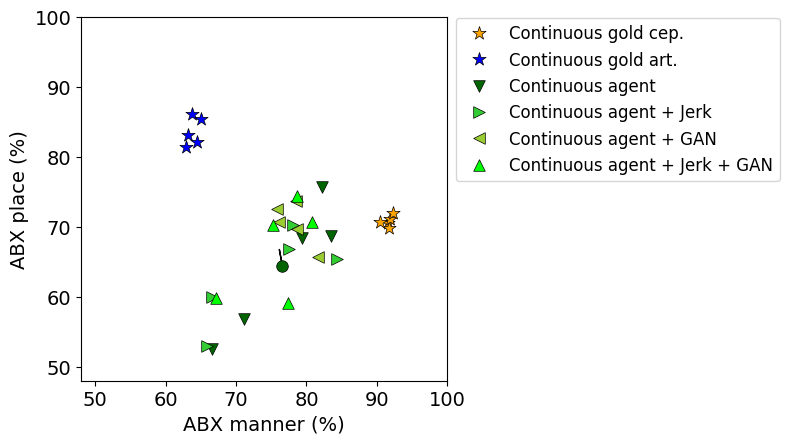

In [35]:
# Comparison communicative vs imitative 
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 14, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':5, 'lines.linewidth':1})

cm = 1/2.54
fig, ax = plt.subplots(1, 1, figsize=(12*cm,12*cm))

alpha = 1
linewidth = .5
s = 100
#ax.scatter(gold_qcep_abx_manner, gold_qcep_abx_place, color='orange', marker='*', s=s, label='Discrete gold cep.', edgecolor='black', linewidth=linewidth)
#ax.scatter(gold_qart_abx_manner, gold_qart_abx_place, color='blue', marker='*', s=s, label='Discrete gold art.', edgecolor='black', linewidth=linewidth)
ax.scatter(gold_cep_abx_manner, gold_cep_abx_place, color='orange', alpha=alpha, marker='*', s=s, label='Continuous gold cep.', edgecolor='black', linewidth=linewidth)
ax.scatter(gold_art_abx_manner, gold_art_abx_place, color='blue', alpha=alpha, marker='*', s=s, label='Continuous gold art.', edgecolor='black', linewidth=linewidth)

s = 70

for agent_type in ['communicative', 'imitative']:
    agent_scores_manner = []
    agent_scores_place = []
    distance = 'art_estimated' if agent_type == 'imitative' else 'art_units'
    color = 'darkgreen' if agent_type == 'imitative' else 'firebrick'
    for condition in ['']: # only base agent, not biased agents
        for seed in range(0,5):
            agent_scores_manner.append(results[agent_type+condition][distance]['manner'])
            agent_scores_place.append(results[agent_type+condition][distance]['place'])
            if agent_type == 'communicative' and condition == '_jerk_gan':
                
                print(agent_type, condition, seed, results[agent_type+condition][distance]['place'])
    X = np.mean(agent_scores_manner)
    Y = np.mean(agent_scores_place)
    if agent_type == 'imitative':
        ax.scatter(X, Y, color=color, marker='o', s=s, zorder=10, edgecolor='black', linewidth=linewidth)

        


# 1. Classic
X = results['imitative']['art_estimated']['manner']
Y = results['imitative']['art_estimated']['place']
ax.scatter(X, Y, alpha=alpha, color='darkgreen', marker='v', s=s, label='Continuous agent', edgecolor='black', linewidth=linewidth)

# 2. Jerk only
X = results['imitative_jerk']['art_estimated']['manner']
Y = results['imitative_jerk']['art_estimated']['place']
ax.scatter(X, Y, alpha=alpha,color='limegreen', marker='>', s=s, label='Continuous agent + Jerk', edgecolor='black', linewidth=linewidth)

# 3. GAN only
X = results['imitative_gan']['art_estimated']['manner']
Y = results['imitative_gan']['art_estimated']['place']
ax.scatter(X, Y, alpha=alpha, color='yellowgreen', marker='<', s=s, label='Continuous agent + GAN', edgecolor='black', linewidth=linewidth)

# 4. Jerk + GAN
X = results['imitative_jerk_gan']['art_estimated']['manner']
Y = results['imitative_jerk_gan']['art_estimated']['place']
ax.scatter(X, Y, alpha=alpha, color='lime', marker='^', s=s, label='Continuous agent + Jerk + GAN', edgecolor='black', linewidth=linewidth)


ax.set_xlim(48,100)
ax.set_ylim(48,100)
ax.set_xlabel('ABX manner (%)')
ax.set_ylabel('ABX place (%)')
h, l = ax.get_legend_handles_labels()
#h = [Line2D([0], [0], color='white', lw=4)] + h[0:2] + [Line2D([0], [0], color='white', lw=4)] + h[2:]
ax.legend(handles=h, fontsize=12, bbox_to_anchor=(1,1.02), ncol=1, columnspacing=0.8)
#plt.legend(fontsize=10, bbox_to_anchor=(1.5,1.02), ncol=3)
x = np.mean(results['imitative']['art_estimated']['manner'])
y = np.mean(results['imitative']['art_estimated']['place'])
dx = np.mean(results['imitative_jerk']['art_estimated']['manner']+
             results['imitative_gan']['art_estimated']['manner']+
            results['imitative_jerk_gan']['art_estimated']['manner'])
dy = np.mean(results['imitative_jerk']['art_estimated']['place']+
             results['imitative_gan']['art_estimated']['place']+
            results['imitative_jerk_gan']['art_estimated']['place'])
dx -= x
dy -= y
ax.arrow(x, y, dx, dy)
plt.savefig('/home/engaclew/agent/out/communicative_vs_imitative/abx_inv.png', bbox_inches='tight', dpi=300)

In [29]:
results

{'imitative': {'art_estimated': {'manner': [71.18333333333334,
    66.60000000000001,
    82.21666666666665,
    79.41666666666669,
    83.44166666666666],
   'place': [56.83333333333332, 52.5, 75.70833333333333, 68.4375, 68.75],
   'global': [73.44590643274854,
    62.046783625730995,
    84.16666666666667,
    82.51315789473685,
    84.83771929824562]}},
 'communicative': {'art_units': {'manner': [81.27,
    76.18333333333332,
    82.56666666666666,
    79.95666666666666,
    82.48333333333333],
   'place': [65.73333333333333,
    65.96666666666667,
    66.275,
    67.69999999999999,
    66.27499999999999],
   'global': [80.11169590643274,
    78.66900584795322,
    80.7672514619883,
    79.953216374269,
    81.27894736842106]}},
 'imitative_jerk': {'art_estimated': {'manner': [65.93,
    78.03999999999999,
    66.63,
    77.5,
    84.33],
   'place': [52.95833333333333,
    70.20833333333333,
    59.983333333333334,
    66.875,
    65.35833333333333],
   'global': [68.48421052631579

In [17]:
for agent_type in ['imitative', 'communicative']:
    distance = 'art_estimated' if agent_type == 'imitative' else 'art_units'
    for condition in ['', '_jerk', '_gan', '_jerk_gan']:
        print(agent_type+condition)
        print("Manner", np.mean(results[agent_type+condition][distance]['manner']), '+/-', 
              np.std(results[agent_type+condition][distance]['manner'],ddof=1))
        print("Place", np.mean(results[agent_type+condition][distance]['place']), '+/-', 
              np.std(results[agent_type+condition][distance]['place'],ddof=1))
        print("Global", np.mean(results[agent_type+condition][distance]['global']), '+/-', 
              np.std(results[agent_type+condition][distance]['global'],ddof=1))
        

imitative
Manner 76.57166666666667 +/- 7.342091361155586
Place 64.44583333333333 +/- 9.512573915612956
Global 77.40204678362572 +/- 9.728924886914124
imitative_jerk
Manner 74.486 +/- 7.961490438353862
Place 63.07666666666667 +/- 6.753580326184196
Global 76.14152046783626 +/- 8.255043724686194
imitative_gan
Manner 78.11999999999999 +/- 2.378923659510282
Place 70.45333333333333 +/- 3.0932138985563578
Global 81.97918128654972 +/- 1.3706952786837512
imitative_jerk_gan
Manner 75.81866666666666 +/- 5.2390009649847515
Place 66.84166666666667 +/- 6.957707057644785
Global 79.13415204678361 +/- 4.647022376675614
communicative
Manner 80.49199999999999 +/- 2.632780110664605
Place 66.38999999999999 +/- 0.766970048669143
Global 80.15602339181287 +/- 0.9860115109728033
communicative_jerk
Manner 78.04333333333332 +/- 3.2850959735684353
Place 63.026666666666664 +/- 2.2964072180497754
Global 77.69649122807017 +/- 1.9404742037518325
communicative_gan
Manner 78.09666666666666 +/- 1.3036657717545703
Place 

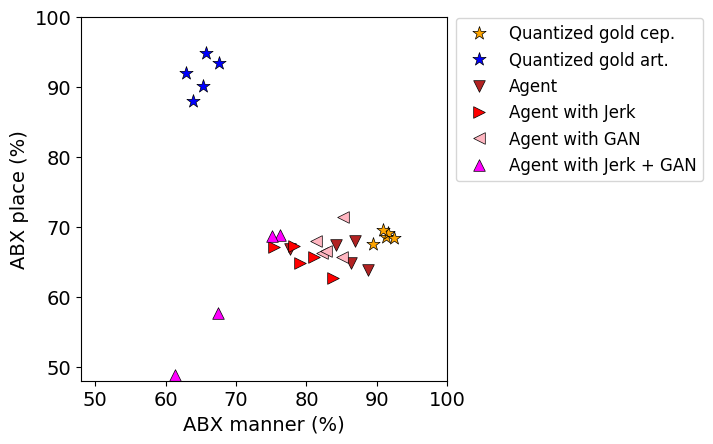

In [56]:
# Study the effect of biases on ABX obtained by quantized articulatory units
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 14, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':5, 'lines.linewidth':1})

cm = 1/2.54
fig, ax = plt.subplots(1, 1, figsize=(12*cm,12*cm))

linewidth = .5
s = 100
ax.scatter(gold_qcep_abx_manner, gold_qcep_abx_place, color='orange', marker='*', s=s, label='Quantized gold cep.', edgecolor='black', linewidth=linewidth)
ax.scatter(gold_qart_abx_manner, gold_qart_abx_place, color='blue', marker='*', s=s, label='Quantized gold art.', edgecolor='black', linewidth=linewidth)

s = 70

# 1. Classic
X = results_quant['communicative']['art_units']['manner']
Y = results_quant['communicative']['art_units']['place']
ax.scatter(X, Y, color='firebrick', marker='v', s=s, label='Agent', edgecolor='black', linewidth=linewidth)

# 2. Jerk only
X = results_quant['communicative_jerk']['art_units']['manner']
Y = results_quant['communicative_jerk']['art_units']['place']
ax.scatter(X, Y, color='red', marker='>', s=s, label='Agent with Jerk', edgecolor='black', linewidth=linewidth)

# 3. GAN only
X = results_quant['communicative_gan']['art_units']['manner']
Y = results_quant['communicative_gan']['art_units']['place']
ax.scatter(X, Y, color='lightpink', marker='<', s=s, label='Agent with GAN', edgecolor='black', linewidth=linewidth)

# 4. Jerk + GAN
X = results_quant['communicative_jerk_gan']['art_units']['manner']
Y = results_quant['communicative_jerk_gan']['art_units']['place']
ax.scatter(X, Y, color='fuchsia', marker='^', s=s, label='Agent with Jerk + GAN', edgecolor='black', linewidth=linewidth)

ax.set_xlim(48,100)
ax.set_ylim(48,100)
ax.set_xlabel('ABX manner (%)')
ax.set_ylabel('ABX place (%)')
h, l = ax.get_legend_handles_labels()
#h = [Line2D([0], [0], color='white', lw=4)] + h[0:2] + [Line2D([0], [0], color='white', lw=4)] + h[2:]
ax.legend(handles=h, fontsize=12, bbox_to_anchor=(1,1.02), ncol=1, columnspacing=0.8)
#plt.legend(fontsize=10, bbox_to_anchor=(1.5,1.02), ncol=3)
plt.savefig('/home/engaclew/agent/out/communicative_vs_imitative/abx_inv_quant.png', bbox_inches='tight')

In [61]:
print(np.mean(results_quant['communicative']['art_units']['manner']))
print(np.mean(results_quant['communicative_jerk']['art_units']['manner']))
print(np.mean(gold_qart_abx_manner))

84.73333333333332
79.49733333333333
65.04666666666667


{'imitative': {'art_estimated': {'manner': [71.18333333333334,
    66.60000000000001,
    82.21666666666665,
    79.41666666666669,
    83.44166666666666],
   'place': [56.83333333333332, 52.5, 75.70833333333333, 68.4375, 68.75],
   'global': [73.44590643274854,
    62.046783625730995,
    84.16666666666667,
    82.51315789473685,
    84.83771929824562]}},
 'communicative': {'art_estimated': {'manner': [86.57000000000001,
    81.48666666666666,
    86.70666666666666,
    83.66333333333333,
    84.68],
   'place': [66.04166666666667,
    66.38333333333333,
    68.85833333333333,
    66.96666666666667,
    68.46666666666667],
   'global': [85.65263157894736,
    82.8093567251462,
    85.73157894736842,
    82.8625730994152,
    83.87251461988305]}},
 'imitative_jerk': {'art_estimated': {'manner': [65.93,
    78.03999999999999,
    66.63,
    77.5,
    84.33],
   'place': [52.95833333333333,
    70.20833333333333,
    59.983333333333334,
    66.875,
    65.35833333333333],
   'global': [6